# Scenarios

This page demonstrates how to run various types of scenarios in Atomica

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import atomica as at
import sciris as sc
import numpy as np
import matplotlib.pyplot as plt
P = at.demo('tb')

Elapsed time for running "default": 0.856s


## Parameter scenarios

A parameter scenario involves making manual changes to parameter values. All parameter scenarios can therefore be thought of as a mapping from `ParameterSet -> ParameterSet` - that is, all of the changes to the simulation in the scenario are expressed as modifications to a `ParameterSet`. There are then two ways of making these changes

1. You can modify the `ParameterSet` directly by adding or removing values
2. You can use the `ParameterScenario` class to automate the most common types of parameter overwrites

Keep in mind that under the hood, the `ParameterScenario` class is simply returning a modified `ParameterSet`, it simply automates making changes to the `ParameterSet`. 


### Using the `ParameterScenario` class

Typical use of parameter scenarios is to modify future parameter values, by using historical values for parameters up to the current year, then explicitly specifying parameter values for future years. You can do this simply by naming the parameter, population, and values.

Consider the baseline birth rate


[<Figure size 614.4x460.8 with 1 Axes>]

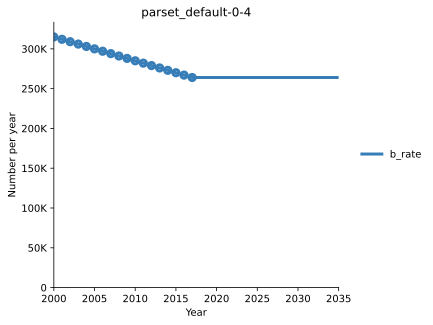

In [2]:
d = at.PlotData(P.results[0],'b_rate','0-4')
at.plot_series(d,data=P.data)

Suppose we wanted to run a scenario where the birth rate was forecasted to continue decreasing. We could create and run a parameter scenario as follows:

Elapsed time for running "default": 0.625s


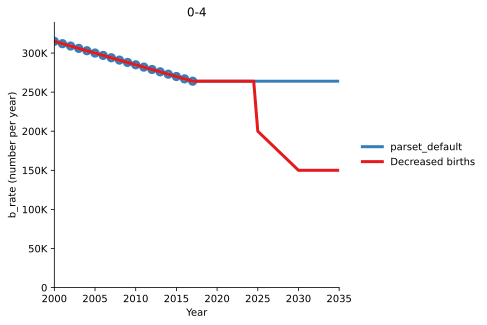

In [3]:
scen = at.ParameterScenario(name='Decreased births')
scen.add('b_rate','0-4',[2025,2030],[200e3,150e3])
res = scen.run(P,P.parsets[0])
d = at.PlotData([P.results[0],res],'b_rate','0-4')
at.plot_series(d,data=P.data,axis='results');

This plot demonstrates a number of features of parameter scenarios as implemented in the `ParameterScenario` class.

#### Scenario start year

The scenario is considered to 'begin' in the first year specified in the overwrite. The baseline parameter value will be used until this initial year. This makes it possible to set the initial overwrite year for each parameter individually. It also avoids ambiguity when interpolating between the last data point and the first overwrite value in cases where the most recent data point is several years out of date (e.g. if the most recent data for a quantity was in 2010 and you want a scenario to start in 2018). 

In the example above, if you wanted to smoothly change the value from 2018 to 2025, you would need to add an extra value in the scenario corresponding to the 2018 value of the quantity:

Elapsed time for running "default": 0.766s


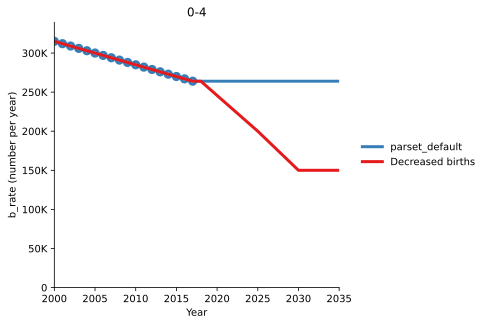

In [4]:
scen.add('b_rate','0-4',[2018,2025,2030],[264e3,200e3,150e3])
res_2018 = scen.run(P,P.parsets[0])
d = at.PlotData([P.results[0],res_2018],'b_rate','0-4')
at.plot_series(d,data=P.data,axis='results');

Notice that calling `scen.add()` replaces the existing overwrite entirely, so we needed to specify all of the values we wanted to overwrite with. 

#### Scenario end year

The `ParameterScenario` never ends, so the final overwrite value is used until the end of the simulation. If you want to have a parameter scenario that ends, you can instead modify the `ParameterSet` directly, as shown in the examples below.

#### Smoothing

The `ParameterScenario` can optionally be smoothed by setting the `interpolation` attribution of the scenario. By default, linear interpolation is used. However, you can use a method like `pchip` to smooth the values if desired.

Elapsed time for running "default": 0.632s


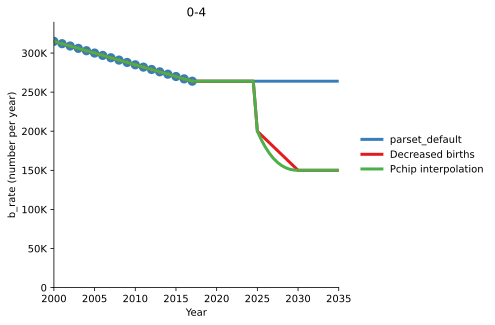

In [5]:
scen.add('b_rate','0-4',[2025,2030],[200e3,150e3])
scen.interpolation = 'pchip'
scen.name = 'Pchip interpolation'
res_smooth = scen.run(P,P.parsets[0])
d = at.PlotData([P.results[0],res,res_smooth],'b_rate','0-4')
at.plot_series(d,data=P.data,axis='results');

<div class="alert alert-danger">
Basic `pchip` interpolation (and also other smoothing methods) does not always produce smooth results, it can depend heavily on the exact data points used. It is better not to rely on it to produce smoothed parameter changes.
</div>

If smoothly changing the value is important, then you should input the smoothed values explicitly when defining the scenario, so that you can be sure the values match up to exactly what you need. You can make use of the `smoothinterp` function from `Sciris` to do this. Notice that we set the time array `t` to have a small step size, close to or equal to the simulation step size. As a result, the interpolation method used by the scenario won't matter, so it can be left as `linear`. 

Elapsed time for running "default": 0.629s


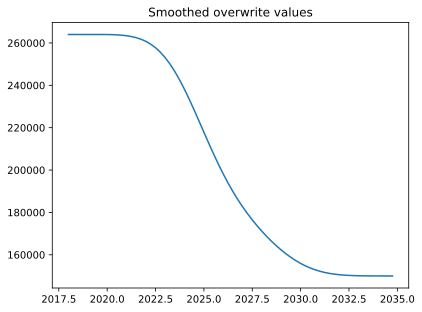

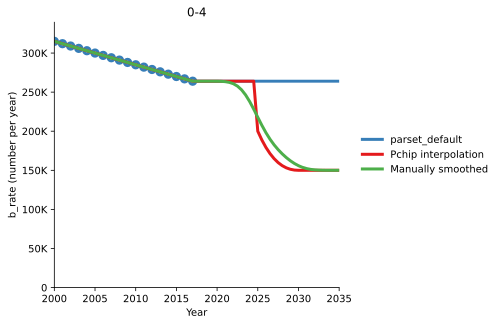

In [6]:
t = np.arange(2018,2035,0.25)
v = sc.smoothinterp(t,[2018,2024,2025,2030],[264e3,264e3,200e3,150e3])
plt.plot(t,v)
plt.title('Smoothed overwrite values')

# Use this overwrite
scen.add('b_rate','0-4',t,v)
scen.interpolation = 'linear' # Reset this to the default, because we have already interp
scen.name = 'Manually smoothed'
res_manually_smooth = scen.run(P,P.parsets[0])
d = at.PlotData([P.results[0],res_smooth,res_manually_smooth],'b_rate','0-4')
at.plot_series(d,data=P.data,axis='results');

#### Step changes

A more common use of interpolation is to implement step changes in parameter value, where the parameter value defined in the scenario is retained until the next overwrite is encountered. This can be achieved by setting the interpolation method to 'previous':

Elapsed time for running "default": 0.628s


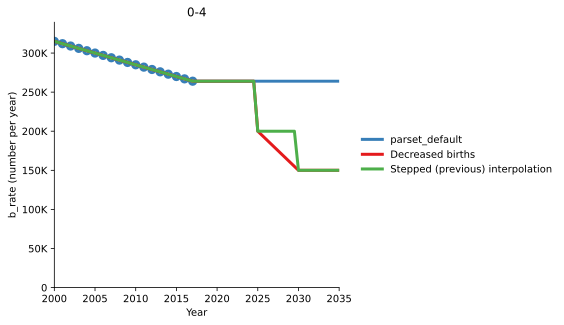

In [7]:
scen.add('b_rate','0-4',[2025,2030],[200e3,150e3])
scen.interpolation = 'previous'
scen.name = 'Stepped (previous) interpolation'
res_smooth = scen.run(P,P.parsets[0])
d = at.PlotData([P.results[0],res,res_smooth],'b_rate','0-4')
at.plot_series(d,data=P.data,axis='results');

#### Parameter interpolation prior to the start year

The scenario will automatically interpolate the baseline parameter values onto all of the simulation years where the baseline is used. Therefore, if you want to apply any smoothing to the parameter values via `Parameter.smooth()` then you should do so before calling `scen.run()`

#### Inspecting the `ParameterSet`

Instead of running a simulation, you can use the `ParameterScenario` object to return a modified `ParameterSet`. You can then examine the `TimeSeries` objects contained in the `ParameterSet` to inspect the values:

In [8]:
parset = scen.get_parset(P.parsets[0],P)
parset.pars['b_rate'].ts['0-4']

[<class 'atomica.utils.TimeSeries'>]
————————————————————————————————————————————————————————————————————————
Methods:
  copy()                  interpolate()           remove_between()        
  get()                   remove()                sample()                
  get_arrays()            remove_after()          insert()                
  remove_before()         
————————————————————————————————————————————————————————————————————————
Properties:
  has_data                has_time_data           
————————————————————————————————————————————————————————————————————————
  _sampled: False
assumption: None
     sigma: None
         t: [2000.0, 2000.5, 2001.0, 2001.5, 2002.0, 2002.5, 2003.0,
            2003.5, 2004. [...]
     units: 'Number (per year)'
      vals: [315000.0, 313500.0, 312000.0, 310500.0, 309000.0,
            307500.0, 306000.0, [...]
————————————————————————————————————————————————————————————————————————

Notice how the `Parameterset` returned by `scen.get_parset()` has already been interpolated onto the project's simulation years. Unless those are changed, no further interpolation will take place when calling `P.run_sim()`.

Calling `scen.run()` is equivalent to constructing a parset as shown above, and then using that parset in `P.run_sim()`. However, retrieving the parset via `scen.get_parset()` allows you to modify it further, or to use it in a subsequent budget scenario or even a calibration or reconciliation if desired. 

### Modifying a `ParameterSet`

If the default parameter scenarios are too restrictive (because of the assumptions they make about start and end years, and because they internally perform interpolation) then you can modify `Parameter` objects directly using the appropriate `TimeSeries` methods. For example

Elapsed time for running "default": 0.621s


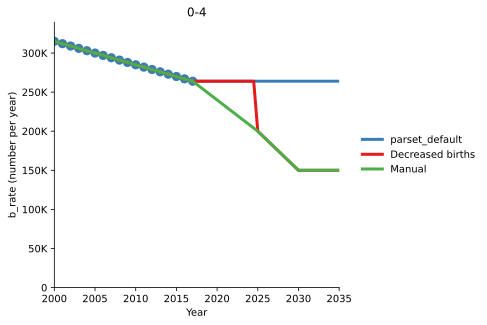

In [9]:
s_parset = sc.dcp(P.parsets[0]) # Don't forget to make a deep copy before modifying
s_parset.pars['b_rate'].ts['0-4'].insert(2025, 200e3)
s_parset.pars['b_rate'].ts['0-4'].insert(2030, 150e3)
res_manual = P.run_sim(s_parset,result_name='Manual')
d = at.PlotData([P.results[0],res,res_manual],'b_rate','0-4')
at.plot_series(d,data=P.data,axis='results');

Notice how because no interpolation was previously done, the resulting manual simulation smoothly changes from 2018 to 2025, unlike the `ParameterScenario`, without needing any values to be specified in 2018. Similarly, if there were additional data points after 2030, those would not be removed here, whereas they would be overwritten by using `ParameterScenario`. Working directly with the `ParameterSet` also gives you more control over when smoothing and interpolation takes place.

### Overwriting function parameters

Finally, it is also possible to overwrite function parameters. Functions are evaluated during model integration, and thus the value of the parameter in the `ParameterSet` is normally overwritten by the evaluated function. Therefore, the `Parameter` contains an attribute, `skip_function`, that stores the range of years over which the parameter function should not be evaluated. If you overwrite a function parameter using a `ParameterScenario`, this is automatically set for you. 

Elapsed time for running "default": 0.807s


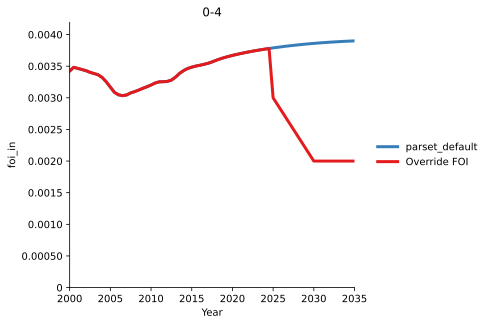

In [10]:
scen = at.ParameterScenario(name='Override FOI')
scen.add('foi_in','0-4',[2025,2030],[0.003, 0.002])
res = scen.run(P,P.parsets[0])
d = at.PlotData([P.results[0],res],'foi_in','0-4')
at.plot_series(d,data=P.data,axis='results');

If you modify a `ParameterSet` directly, then you need to also set this flag. If you do not set this flag, then the parameter function will overwrite the values entered, and you won't see any difference

Elapsed time for running "default": 0.624s


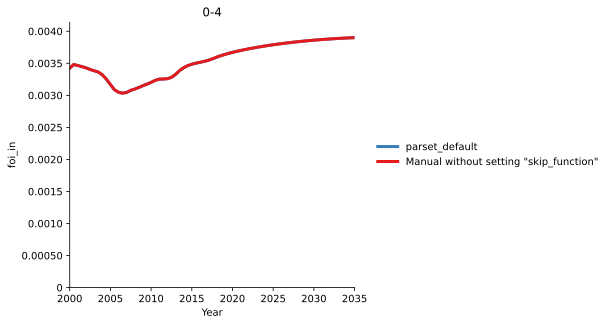

In [11]:
s_parset = sc.dcp(P.parsets[0]) # Don't forget to make a deep copy before modifying
s_parset.pars['foi_in'].ts['0-4'].insert(2025, 0.003)
s_parset.pars['foi_in'].ts['0-4'].insert(2030, 0.002)
res_manual = P.run_sim(s_parset,result_name='Manual without setting "skip_function"')
d = at.PlotData([P.results[0],res_manual],'foi_in','0-4')
at.plot_series(d,data=P.data,axis='results');

Elapsed time for running "default": 0.604s


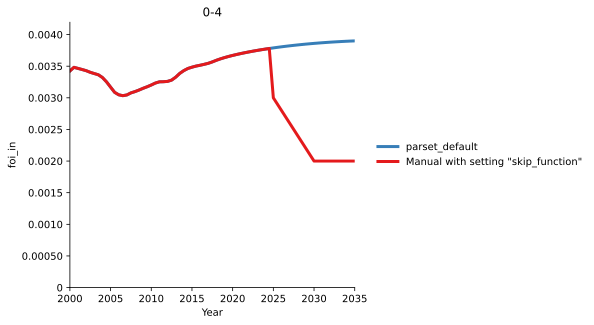

In [12]:
s_parset.pars['foi_in'].skip_function['0-4'] = (2025, np.inf)
res_manual = P.run_sim(s_parset,result_name='Manual with setting "skip_function"')
d = at.PlotData([P.results[0],res_manual],'foi_in','0-4')
at.plot_series(d,data=P.data,axis='results');

Notice that the `skip_function` attribute requires both the start and stop year. To never turn the function back on, use `np.inf` as the stop year. On the other hand, you can set this to a year when you want the function to reactivate if required:

Elapsed time for running "default": 0.613s


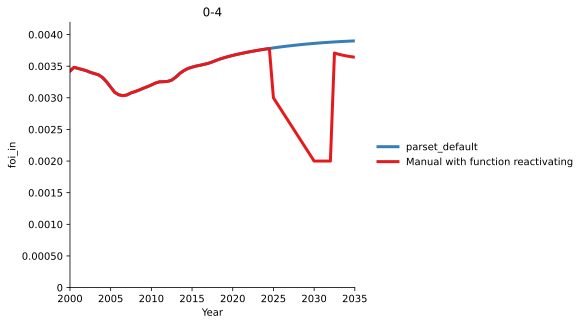

In [13]:
s_parset.pars['foi_in'].skip_function['0-4'] = (2025, 2032)
res_manual = P.run_sim(s_parset,result_name='Manual with function reactivating')
d = at.PlotData([P.results[0],res_manual],'foi_in','0-4')
at.plot_series(d,data=P.data,axis='results');

Notice how when the function reactivates, the evaluated value is not the same as the baseline scenario. This is because the parameter overwrite from 2025 to 2032 has affected other parts of the model, and thus evaluating the parameter function in 2032 onwards produces a different result to the baseline case.